# Task 1 : Set up colab gpu runtime environment

In [3]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 54.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=9a2a39ebc66e78d903924918fc4f6355b2e6027f9e53af6690e5dd4e74de07c5
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=92e8c9a127e61bc849495f6677d1b7dc978a23f216d125808645703c60305b40
  Stored in directory: /root/.cache/pip/w

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [4]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 18.62 MiB/s, done.
Resolving deltas: 100% (3/3), done.


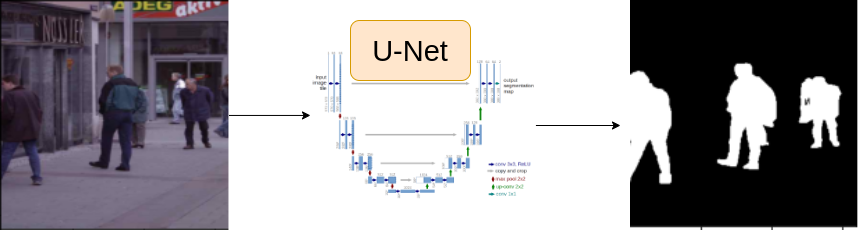

# Some Common Imports

In [5]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [6]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [33]:
csv_file = '/content/Human-Segmentation-Dataset-master/train.csv'
data_dir = '/content/'
device = 'cuda'
epochs = 25
lr = 0.003
image_size = 320
batch_size = 16
encoder = 'timm-efficientnet-b0'
weights = 'imagenet'

In [8]:
df = pd.read_csv(csv_file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [9]:
row = df.iloc[4]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

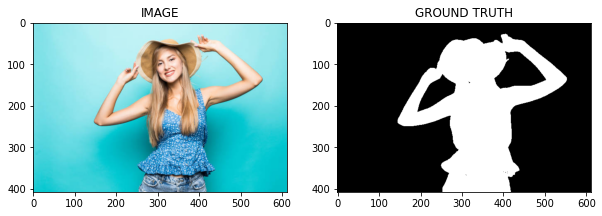

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [11]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [12]:
import albumentations as A

In [13]:
from albumentations.augmentations.geometric.transforms import VerticalFlip
def get_train_augs():
  return A.Compose([
      A.Resize(image_size, image_size),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)     
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(image_size, image_size),    
  ])

# Task 4 : Create Custom Dataset 

In [14]:
from torch.utils.data import Dataset

In [15]:
class SegmentationDataset(Dataset):
  
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    
    row = self.df.iloc[index]
    
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(heigth, width, channel)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    #(h,w,c) --> (c,h,w)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) /255.0)
    
    return image, mask

In [16]:
train_set = SegmentationDataset(train_df, get_train_augs())
valid_set = SegmentationDataset(valid_df, get_valid_augs())

In [17]:
print(f"Size of Trainset : {len(train_set)}")
print(f"Size of Validset : {len(valid_set)}")

Size of Trainset : 232
Size of Validset : 58


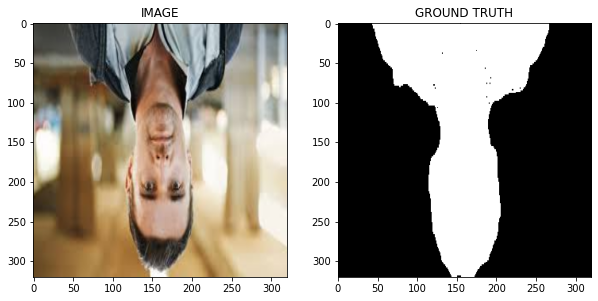

In [19]:
index = 32
image, mask = train_set[index]

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [19]:
from torch.utils.data import DataLoader

In [31]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

In [34]:
print(train_loader)
for image, mask in train_loader:
  break

print(f"img shape: {image.shape}")
print(f"mask shape: {mask.shape}")

ValueError: ignored

# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
from torch.nn.modules import BCEWithLogitsLoss
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(encoder_name= encoder, 
                        encoder_weights=weights, 
                        in_channels=3, 
                        classes=1, 
                        activation=None)
  
  def forward(self, images, masks=None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = BCEWithLogitsLoss()(logits, masks)

      return logits, loss1 + loss2

    return logits

In [23]:
model = SegmentationModel()
model.to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function 

In [24]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm (data_loader):

    images = images.to(device)
    masks = masks.to(device)

    optimizer.zero_grad()

    logits, loss = model(images, masks)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [25]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm (data_loader):

      images = images.to(device)
      masks = masks.to(device)

      logits, loss = model(images, masks)  

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [27]:
best_valid_loss = np.Inf

for i in range(epochs):
  train_loss = train_fn(train_loader, model, optimizer)
  valid_loss = eval_fn(valid_loader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state.dict(), 'best_model.pt')
    best_valid_loss = valid_loss

  print(f"Epochs: {i+1} Train loss: {train_loss} Valid loss: {valid_loss}")

  0%|          | 0/15 [00:00<?, ?it/s]


ValueError: ignored

# Task 9 : Inference

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya